In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# interest rate for Net Present Value calculations
rate = 4/100; # 4.0#
# data for generator dispatch problem
D = 365; # days in a year
Y = 20; # years simulated
T = 24; # hours simulated in each day
t= np.arange(T); # vector of time
d = 40 * np.array([
    0.4, 0.4, 0.4, 0.65,
    0.65, 0.6, 0.6, 0.65,
    0.8, 0.85, 0.8, 0.8,
    0.75, 0.6, 0.5, 0.3, 
    0.3, 0.4, 0.54, 0.6, 
    0.75, 0.7, 0.6, 0.5
]) # daily demand in MWh
n = 4; # number of dispatchable generators (2 hard coal and 2 OCGT plants) to choose from,
# in addition to a solar plant
solar_cap_fact = np.concatenate((
    np.zeros(6),
    np.sin(np.pi*np.arange(0, 13)/12),
    np.zeros(24-6-(np.arange(0,13).size))
))
# capacity factor of the potential solar plant = power_available/installed_capacity
# (To be used in Part II only: capacity factor of the potential wind plant = power_available/installed_capacity)
wind_cap_fact = np.array([
    0.3277, 0.2865, 0.3303, 0.3073, 0.2994, 0.3071,
    0.2980, 0.2988, 0.3149, 0.3141, 0.3142, 0.5*0.3067, 
    0.5*0.2879, 0.5*0.3072, 0.5*0.3163, 0.5*0.3049, 0.5*0.3103, 
    0.3914, 0.4008 , 0.3879, 0.3889, 0.3999, 0.4153, 0.3923
])
Pmax = np.array([10, 5, 10, 15]) 
# Maximum generator capacities in MW [hard coal, hard coal, OCGT, OCGT] due to land constraints
Pmax_solar = 40; # Maximum capacity in MW for solar plant due to land constraints
Pmin = np.zeros(4) # generator minimum capacities in MW
Pmin_solar = 0;
ramp_hard_coal = 0.015 # 1.5# [# Pnom/minute]
hourly_ramp_hard_coal = ramp_hard_coal*60; # [# Pnom/h]
ramp_ocgt = 0.08 # 1.5# [# Pnom/min]
hourly_ramp_ocgt = ramp_ocgt*60; # [# Pnom/h]
R = np.array([hourly_ramp_hard_coal, hourly_ramp_hard_coal, hourly_ramp_ocgt, hourly_ramp_ocgt]) * Pmax 
# [hourly_ramp_hard_coal*Pmax[0], hourly_ramp_hard_coal*Pmax[1], hourly_ramp_ocgt*Pmax[2], hourly_ramp_ocgt*Pmax[3]]; # ramp-rate limits [MWh]
# source:
# https://www.eia.gov/electricity/annual/html/epa_08_04.html
#
fuel_cost_per_MWh_2018 = np.array([25.4, 25.4, 27.35, 27.35]); # $/MWh, 2018
#
#fuel_cost_per_MWh_2019 = [24.28 24.28 23.11 23.11]; # $/MWh, 2019 This
#cost won't be used
# Investment costs (or capital costs per MW of built capacity). From https://atb.nrel.gov/
capital_cost_solar_plant_per_MW = 1200000; # dollars/MW, denoted as M_i in the pdf
capital_cost_wind_plant_per_MW = 1300000; # dollars/MW, denoted as M_i in the pdf
capital_cost_coal_plant = 4200000; # dollars/MW, denoted as M_i in the pdf
capital_cost_gas_plant = 2600000; # dollars/MW, denoted as M_i in the pdf
# Emission rates of pounds of CO_2 per kWh for each tech (https://www.eia.gov/tools/faqs/faq.php?id=74&t=11)
co2_coal = 2.30; # pounds per kWh
co2_gas = 0.97; # pounds per kWh
co2_solar = 0;
# Remember to convert these to pounds/MWh for consistency in your units
# co2_emissions = [];
## Solution
## Optimal capacity and hourly dispatch

# Part I

In [3]:
# define variables
p = cp.Variable((n, T))
p_solar = cp.Variable(T)
installed_thermal_capacity = cp.Variable(n)
installed_solar_capacity = cp.Variable();

# define constraints
constraints = [
    installed_thermal_capacity >= Pmin,
    installed_solar_capacity >= Pmin_solar,
    installed_thermal_capacity <= Pmax,
    installed_solar_capacity <= Pmax_solar,
    cp.sum(p, axis=0) + p_solar >= d,
    p >= 0,
    p_solar >= 0,
    p <= installed_thermal_capacity[:, np.newaxis],
    p_solar <= solar_cap_fact * installed_solar_capacity,
    cp.abs(cp.diff(p, axis=1)) <= R[:, np.newaxis]
]

# define costs
thermal_investment_costs = cp.multiply(
    [capital_cost_coal_plant]*2 + [capital_cost_gas_plant]*2,
    installed_thermal_capacity
)
solar_investment_cost = capital_cost_solar_plant_per_MW * installed_solar_capacity

daily_fuel_costs = cp.sum(cp.multiply(p, fuel_cost_per_MWh_2018[:, np.newaxis]), axis=1)
NPV_multipliers = np.power((1 + rate), -1 * (np.arange(20)+1))
NPV_fuel_costs = cp.multiply(365*daily_fuel_costs[:, np.newaxis], NPV_multipliers)

# solve
problem = cp.Problem(cp.Minimize(
    cp.sum(NPV_fuel_costs) + cp.sum(thermal_investment_costs) + solar_investment_cost
), constraints)

problem.solve()

total_NPV_cost = problem.value
installed_capacity = np.concatenate((installed_thermal_capacity.value, [installed_solar_capacity.value]))
power_generation = np.concatenate((p.value, p_solar.value[np.newaxis, :]))
investment_costs = np.concatenate((thermal_investment_costs.value, [solar_investment_cost.value]))
plant_NPV_fuel_costs = np.concatenate((np.sum(NPV_fuel_costs.value, axis=1), [0]))

C:\Users\LW\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


## Part I report

In [4]:
# report
power_plants = ['Coal 1', 'Coal 2', 'Gas 1', 'Gas 2', 'Solar']

print(f'2. The NPV of of the cost is ${total_NPV_cost:_.2f}')
print(f'3. The optimal installed capacities are: ')

for i in range(5):
    print(f'\t {power_plants[i]}: {installed_capacity[i]:.3f} MW')

2. The NPV of of the cost is $162_532_337.44
3. The optimal installed capacities are: 
	 Coal 1: 2.447 MW
	 Coal 2: 2.553 MW
	 Gas 1: 10.000 MW
	 Gas 2: 15.000 MW
	 Solar: 5.657 MW


Text(0.5, 0.98, '4. Part I plots')

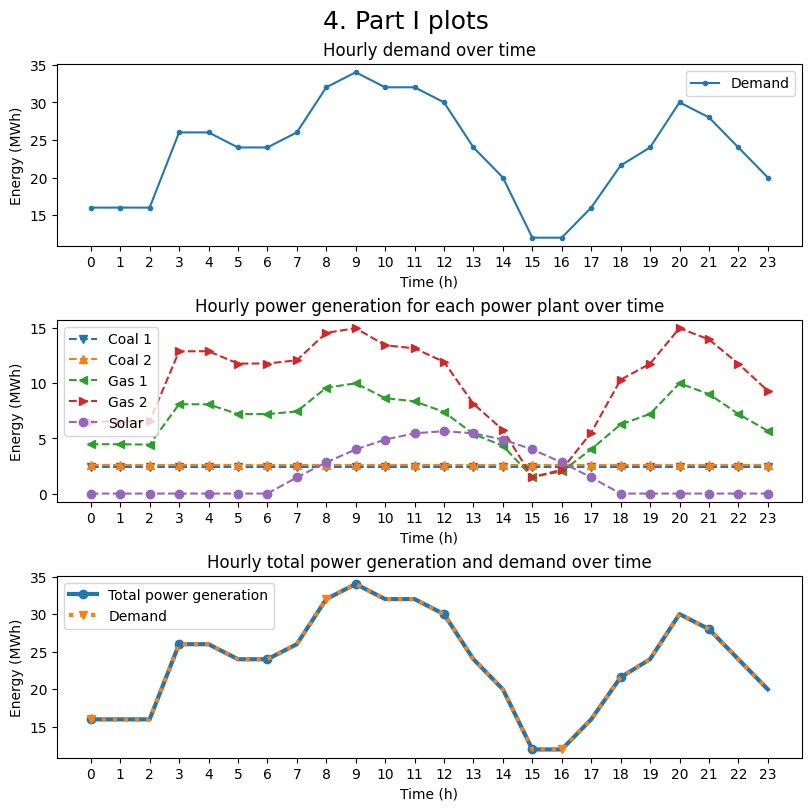

In [5]:
# figures
fig, ax = plt.subplots(3, layout='constrained', figsize=(8, 8))

markers = ['v', '^', '<', '>', 'o']

ax[0].plot(t, d, marker='.', label='Demand')
ax[0].set_title('Hourly demand over time')

for i in range(5):
    ax[1].plot(t, power_generation[i, :], ls='--', marker=markers[i], label=power_plants[i])

ax[1].set_title('Hourly power generation for each power plant over time')

ax[2].plot(t,  np.sum(power_generation, axis=0), ls='-', lw=3, marker='o', markevery=3, label='Total power generation')
ax[2].plot(t,  d, ls=':', lw=3, marker='v', markevery=8, label='Demand')
ax[2].set_title('Hourly total power generation and demand over time')

for i in range(3):
    ax[i].set_xlabel('Time (h)')
    ax[i].set_xticks(t)
    ax[i].set_ylabel('Energy (MWh)')
    ax[i].legend()

fig.suptitle('4. Part I plots', fontsize=18)

In [6]:
# LCOE
yearly_dispatched_electricity = 365 * np.sum(power_generation, axis=1)
NPV_optimal_dispatched_electricity = np.sum(yearly_dispatched_electricity[:, np.newaxis]*NPV_multipliers, axis=1)

LCOE = (investment_costs+plant_NPV_fuel_costs) / NPV_optimal_dispatched_electricity

print('5.')
for i in range(5):
    print(f'\tLCOE of {power_plants[i]}: ${LCOE[i]:.2f}/MWh')

5.
	LCOE of Coal 1: $60.68/MWh
	LCOE of Coal 2: $60.68/MWh
	LCOE of Gas 1: $60.50/MWh
	LCOE of Gas 2: $59.51/MWh
	LCOE of Solar: $31.85/MWh


## Part I questions
1. The hourly dispatch shows that the hourly total power generation is equal to the power demand, which means that there is no curtailment. This is the optimal solution because it means that no escess money is spent on fueling thermal plants to produce more power than needed.
2. The driving factors that affect the installed capacities are:
3. The maximum capacity for the two gas plants were active constraints.
4. Solar has the least LCOE. The 2 gas plants have the next lowest LCOE. The coal plants have the highest LCOE. The optimization maximizes the cheaper LCOE solar first, but since solar cannot cover nighttime demand, the optimizer maximizes the next cheapest option which is gas.

# Part II

In [7]:
# define variables
Pmin_wind = 0
p = cp.Variable((n, T))
p_solar = cp.Variable(T)
p_wind = cp.Variable(T)
installed_thermal_capacity = cp.Variable(n)
installed_solar_capacity = cp.Variable()
installed_wind_capacity = cp.Variable()

# define constraints
constraints = [
    installed_thermal_capacity >= Pmin,
    installed_solar_capacity >= Pmin_solar,
    installed_wind_capacity >= Pmin_wind,
    installed_thermal_capacity <= Pmax,
    cp.sum(p, axis=0) + p_solar + p_wind >= d,
    p >= 0,
    p_solar >= 0,
    p_wind >= 0,
    p <= installed_thermal_capacity[:, np.newaxis],
    p_solar <= solar_cap_fact * installed_solar_capacity,
    p_wind <= wind_cap_fact * installed_wind_capacity,
    cp.abs(cp.diff(p, axis=1)) <= R[:, np.newaxis]
]

RPS = (cp.sum(p_solar)+cp.sum(p_wind)) / cp.sum(d)
RPS_constraints = np.concatenate(([0], np.arange(0.94, 1, 0.01)))

# define costs
thermal_investment_costs = cp.multiply(
    [capital_cost_coal_plant]*2 + [capital_cost_gas_plant]*2,
    installed_thermal_capacity
)
solar_investment_cost = capital_cost_solar_plant_per_MW * installed_solar_capacity
wind_investment_cost = capital_cost_wind_plant_per_MW * installed_wind_capacity

fuel_costs = 365 * cp.multiply(p, fuel_cost_per_MWh_2018[:, np.newaxis])
NPV_fuel_costs = fuel_costs/(1 + rate)

# solve
total_NPV_costs = np.zeros(8)
installed_capacities_2 = np.zeros((8, 6))
curtailments = np.zeros(8)
RPS_values = np.zeros(8)
power_generation_2 = np.zeros((8, 6, 24))

for i in range(8):
    problem = cp.Problem(cp.Minimize(
            cp.sum(NPV_fuel_costs) 
            + cp.sum(thermal_investment_costs) 
            + solar_investment_cost 
            + wind_investment_cost
        ), constraints + [RPS >= RPS_constraints[i]]
    )
    problem.solve()

    total_NPV_costs[i] = problem.value
    installed_capacities_2[i, :] = np.concatenate((
        installed_thermal_capacity.value,
        [installed_solar_capacity.value],
        [installed_wind_capacity.value]
    ))
    curtailments[i] = np.sum(p.value) + np.sum(p_solar.value) + np.sum(p_wind.value) - np.sum(d)
    RPS_values[i] = RPS.value
    power_generation_2[i, :, :] = np.concatenate((
        p.value,
        p_solar.value[np.newaxis, :],
        p_wind.value[np.newaxis, :]
    ))

    print(f'RPS\t{RPS.value:.2%}')
    print(f'Total NP:\t{problem.value}')
    print(f'Thermal capacity:\t{installed_thermal_capacity.value}')
    print(f'Solar capacity:\t{installed_solar_capacity.value}')
    print(f'Wind capacity:\t{installed_wind_capacity.value}')
    print('')

RPS	25.54%
Total NP:	94176395.5053705
Thermal capacity:	[2.18894578e-07 2.18748531e-07 1.00000000e+01 1.50000000e+01]
Solar capacity:	7.0168846366943445
Wind capacity:	12.856774151913072

RPS	94.00%
Total NP:	117084477.0556657
Thermal capacity:	[3.84718175e-09 3.83664750e-09 4.15573964e+00 4.24051846e+00]
Solar capacity:	15.10184578586974
Wind capacity:	58.796733079411

RPS	95.00%
Total NP:	117534891.5000247
Thermal capacity:	[1.45785862e-08 1.45571533e-08 4.05531090e+00 4.13543527e+00]
Solar capacity:	15.205632787676553
Wind capacity:	59.48314552673359

RPS	96.00%
Total NP:	117987162.63397805
Thermal capacity:	[1.43088300e-08 1.42174755e-08 3.95469837e+00 4.03053591e+00]
Solar capacity:	15.309419779115204
Wind capacity:	60.16955797078226

RPS	97.00%
Total NP:	118442484.33594993
Thermal capacity:	[3.05963250e-09 3.04566678e-09 3.85502054e+00 3.92470190e+00]
Solar capacity:	15.41320676561363
Wind capacity:	60.85597040744284

RPS	98.00%
Total NP:	118897806.02759486
Thermal capacity:	[4.8

Text(0.5, 0.98, 'Part II summary plots')

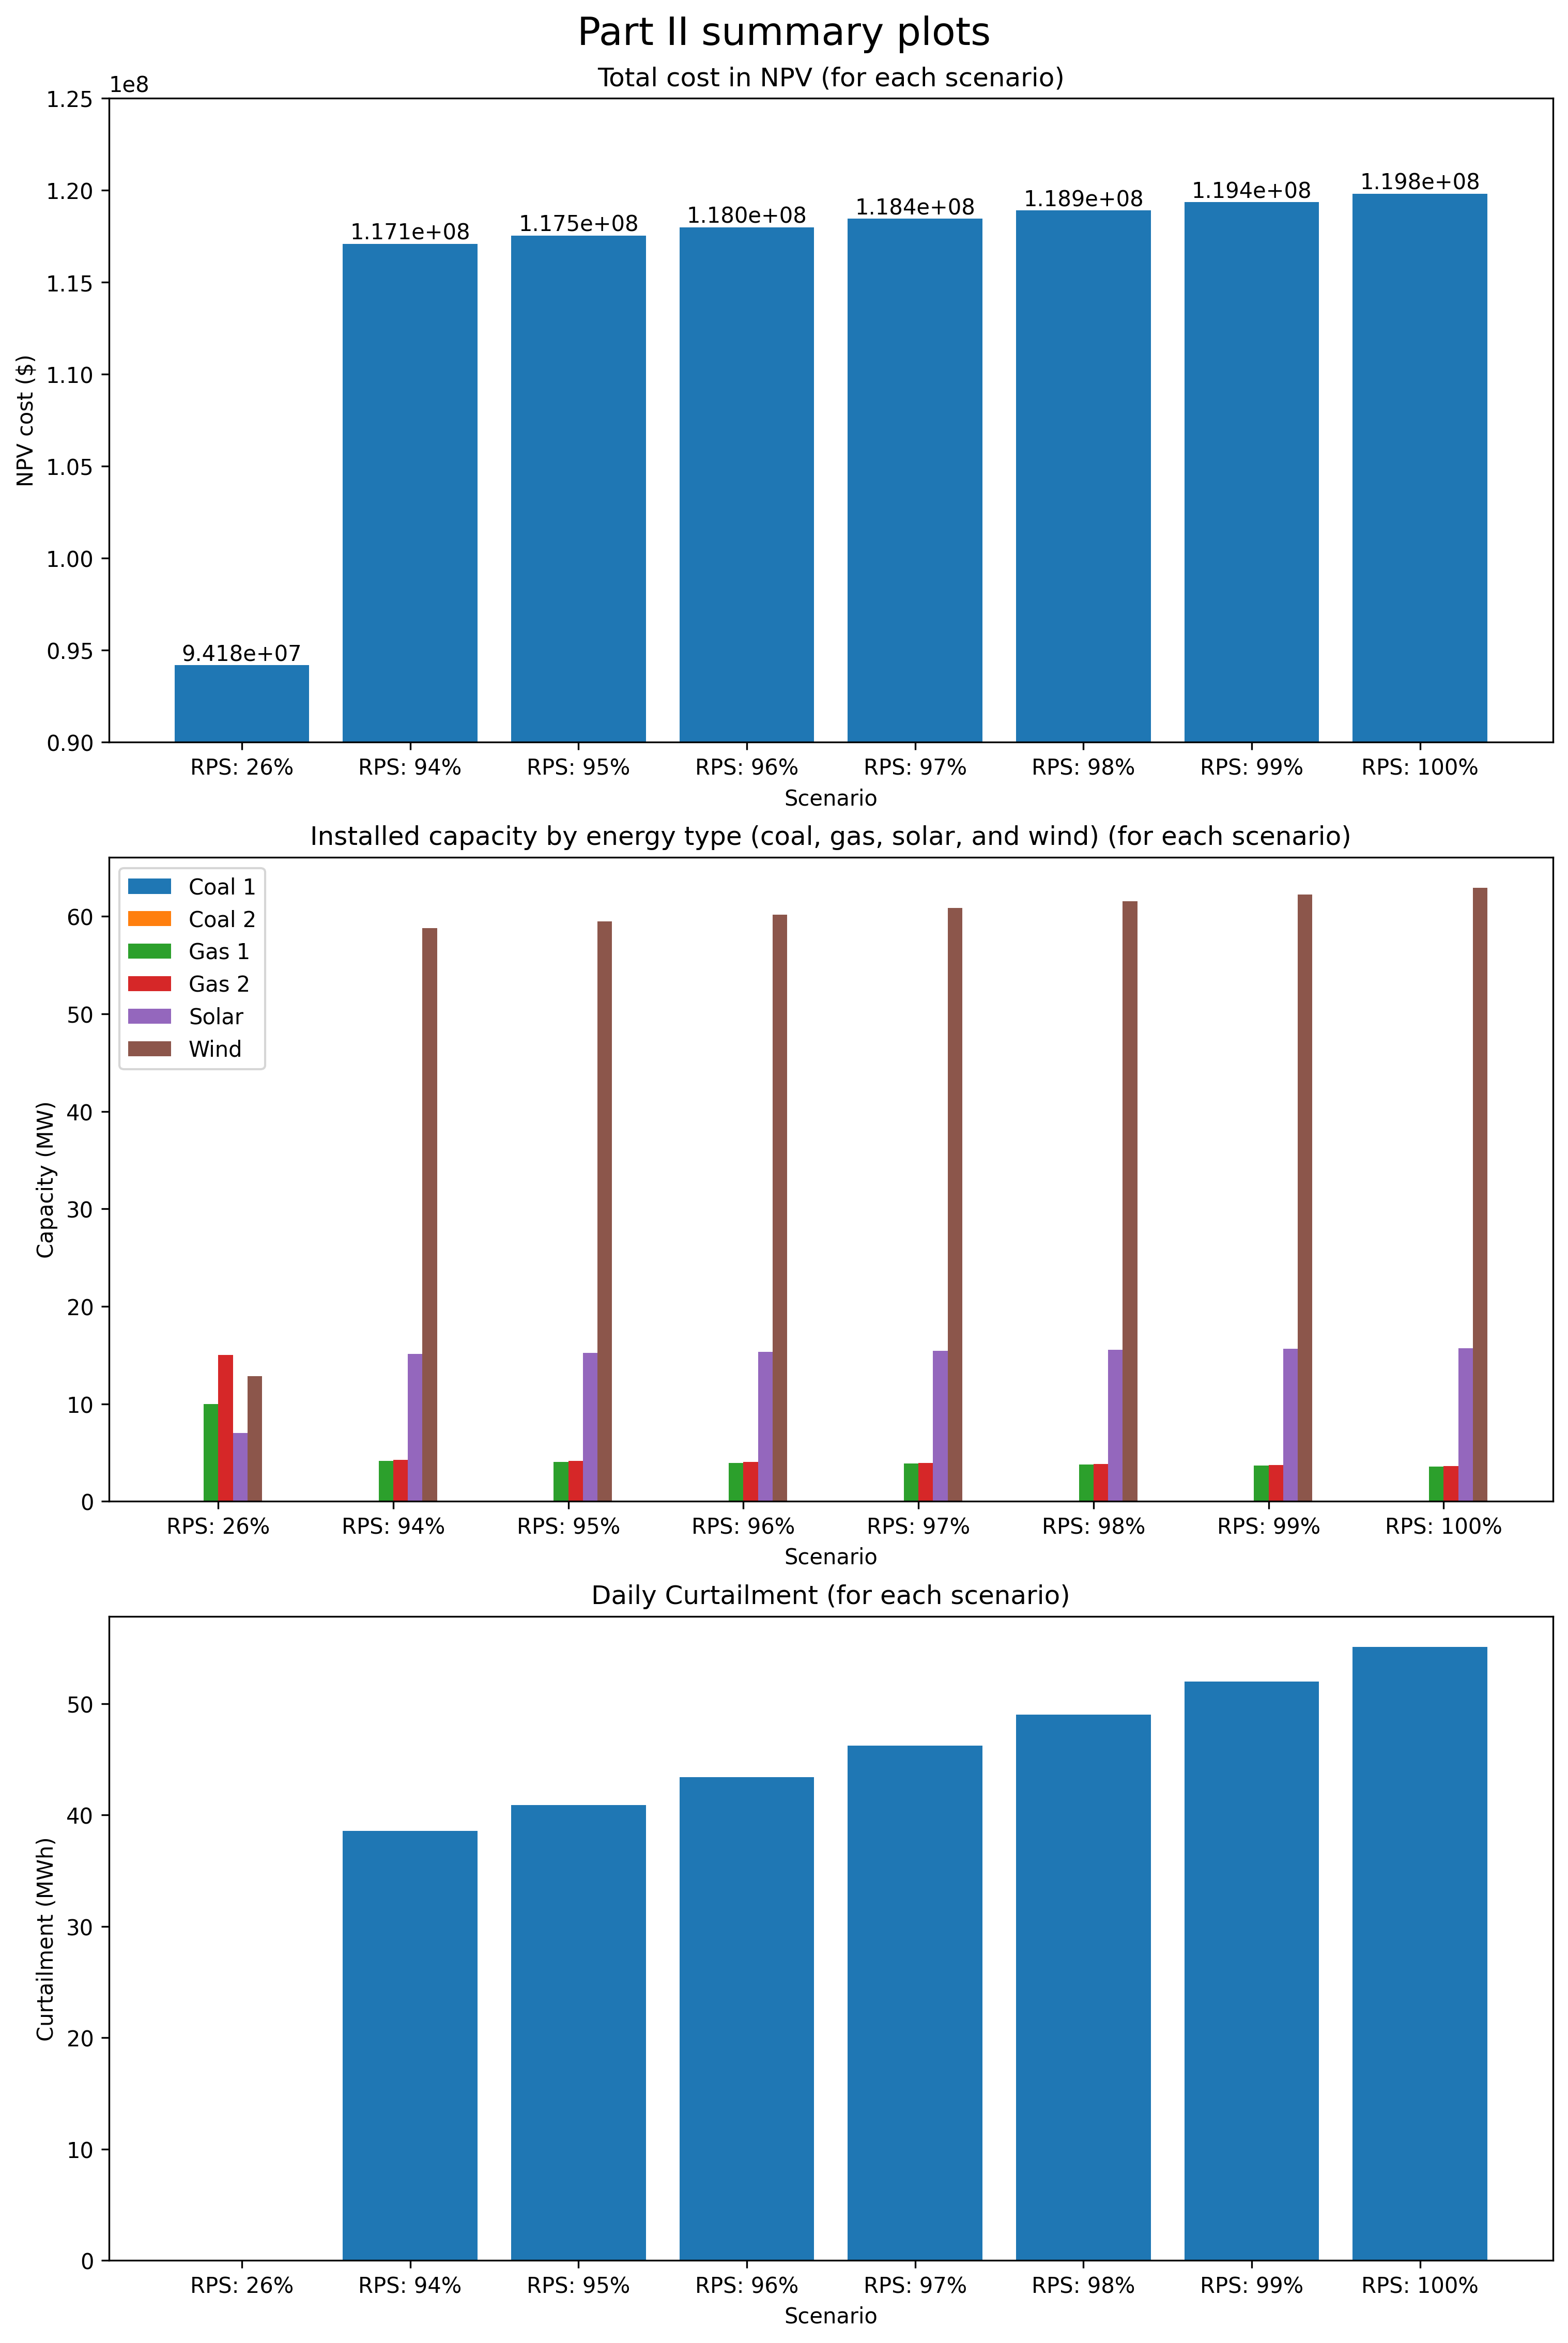

In [8]:
fig, ax = plt.subplots(3, figsize=(10, 15), layout='constrained', dpi=300)

rects = ax[0].bar(range(8), total_NPV_costs)
ax[0].bar_label(rects, fmt='{:_.3e}')
ax[0].set_ylim((9e7, 1.25e8))
ax[0].set_ylabel('NPV cost ($)')
ax[0].set_title('Total cost in NPV (for each scenario)')

power_plants = ['Coal 1', 'Coal 2', 'Gas 1', 'Gas 2', 'Solar', 'Wind']
offsets = (np.arange(-3, 3)+0.5) / 12
for i in range(6):
    ax[1].bar(np.arange(8)+offsets[i], installed_capacities_2[:, i], width=1/12, label=power_plants[i])
    
ax[1].set_ylabel('Capacity (MW)')
ax[1].set_title('Installed capacity by energy type (coal, gas, solar, and wind) (for each scenario)')
ax[1].legend()

ax[2].bar(range(8), curtailments)
ax[2].set_ylabel('Curtailment (MWh)')
ax[2].set_title('Daily Curtailment (for each scenario)')

scenarios = [f'RPS: {rps:.0%}' for rps in RPS_values]
for a in ax:
    a.set_xlabel('Scenario')
    a.set_xticks(np.arange(8), scenarios)

fig.suptitle('Part II summary plots', fontsize=18)

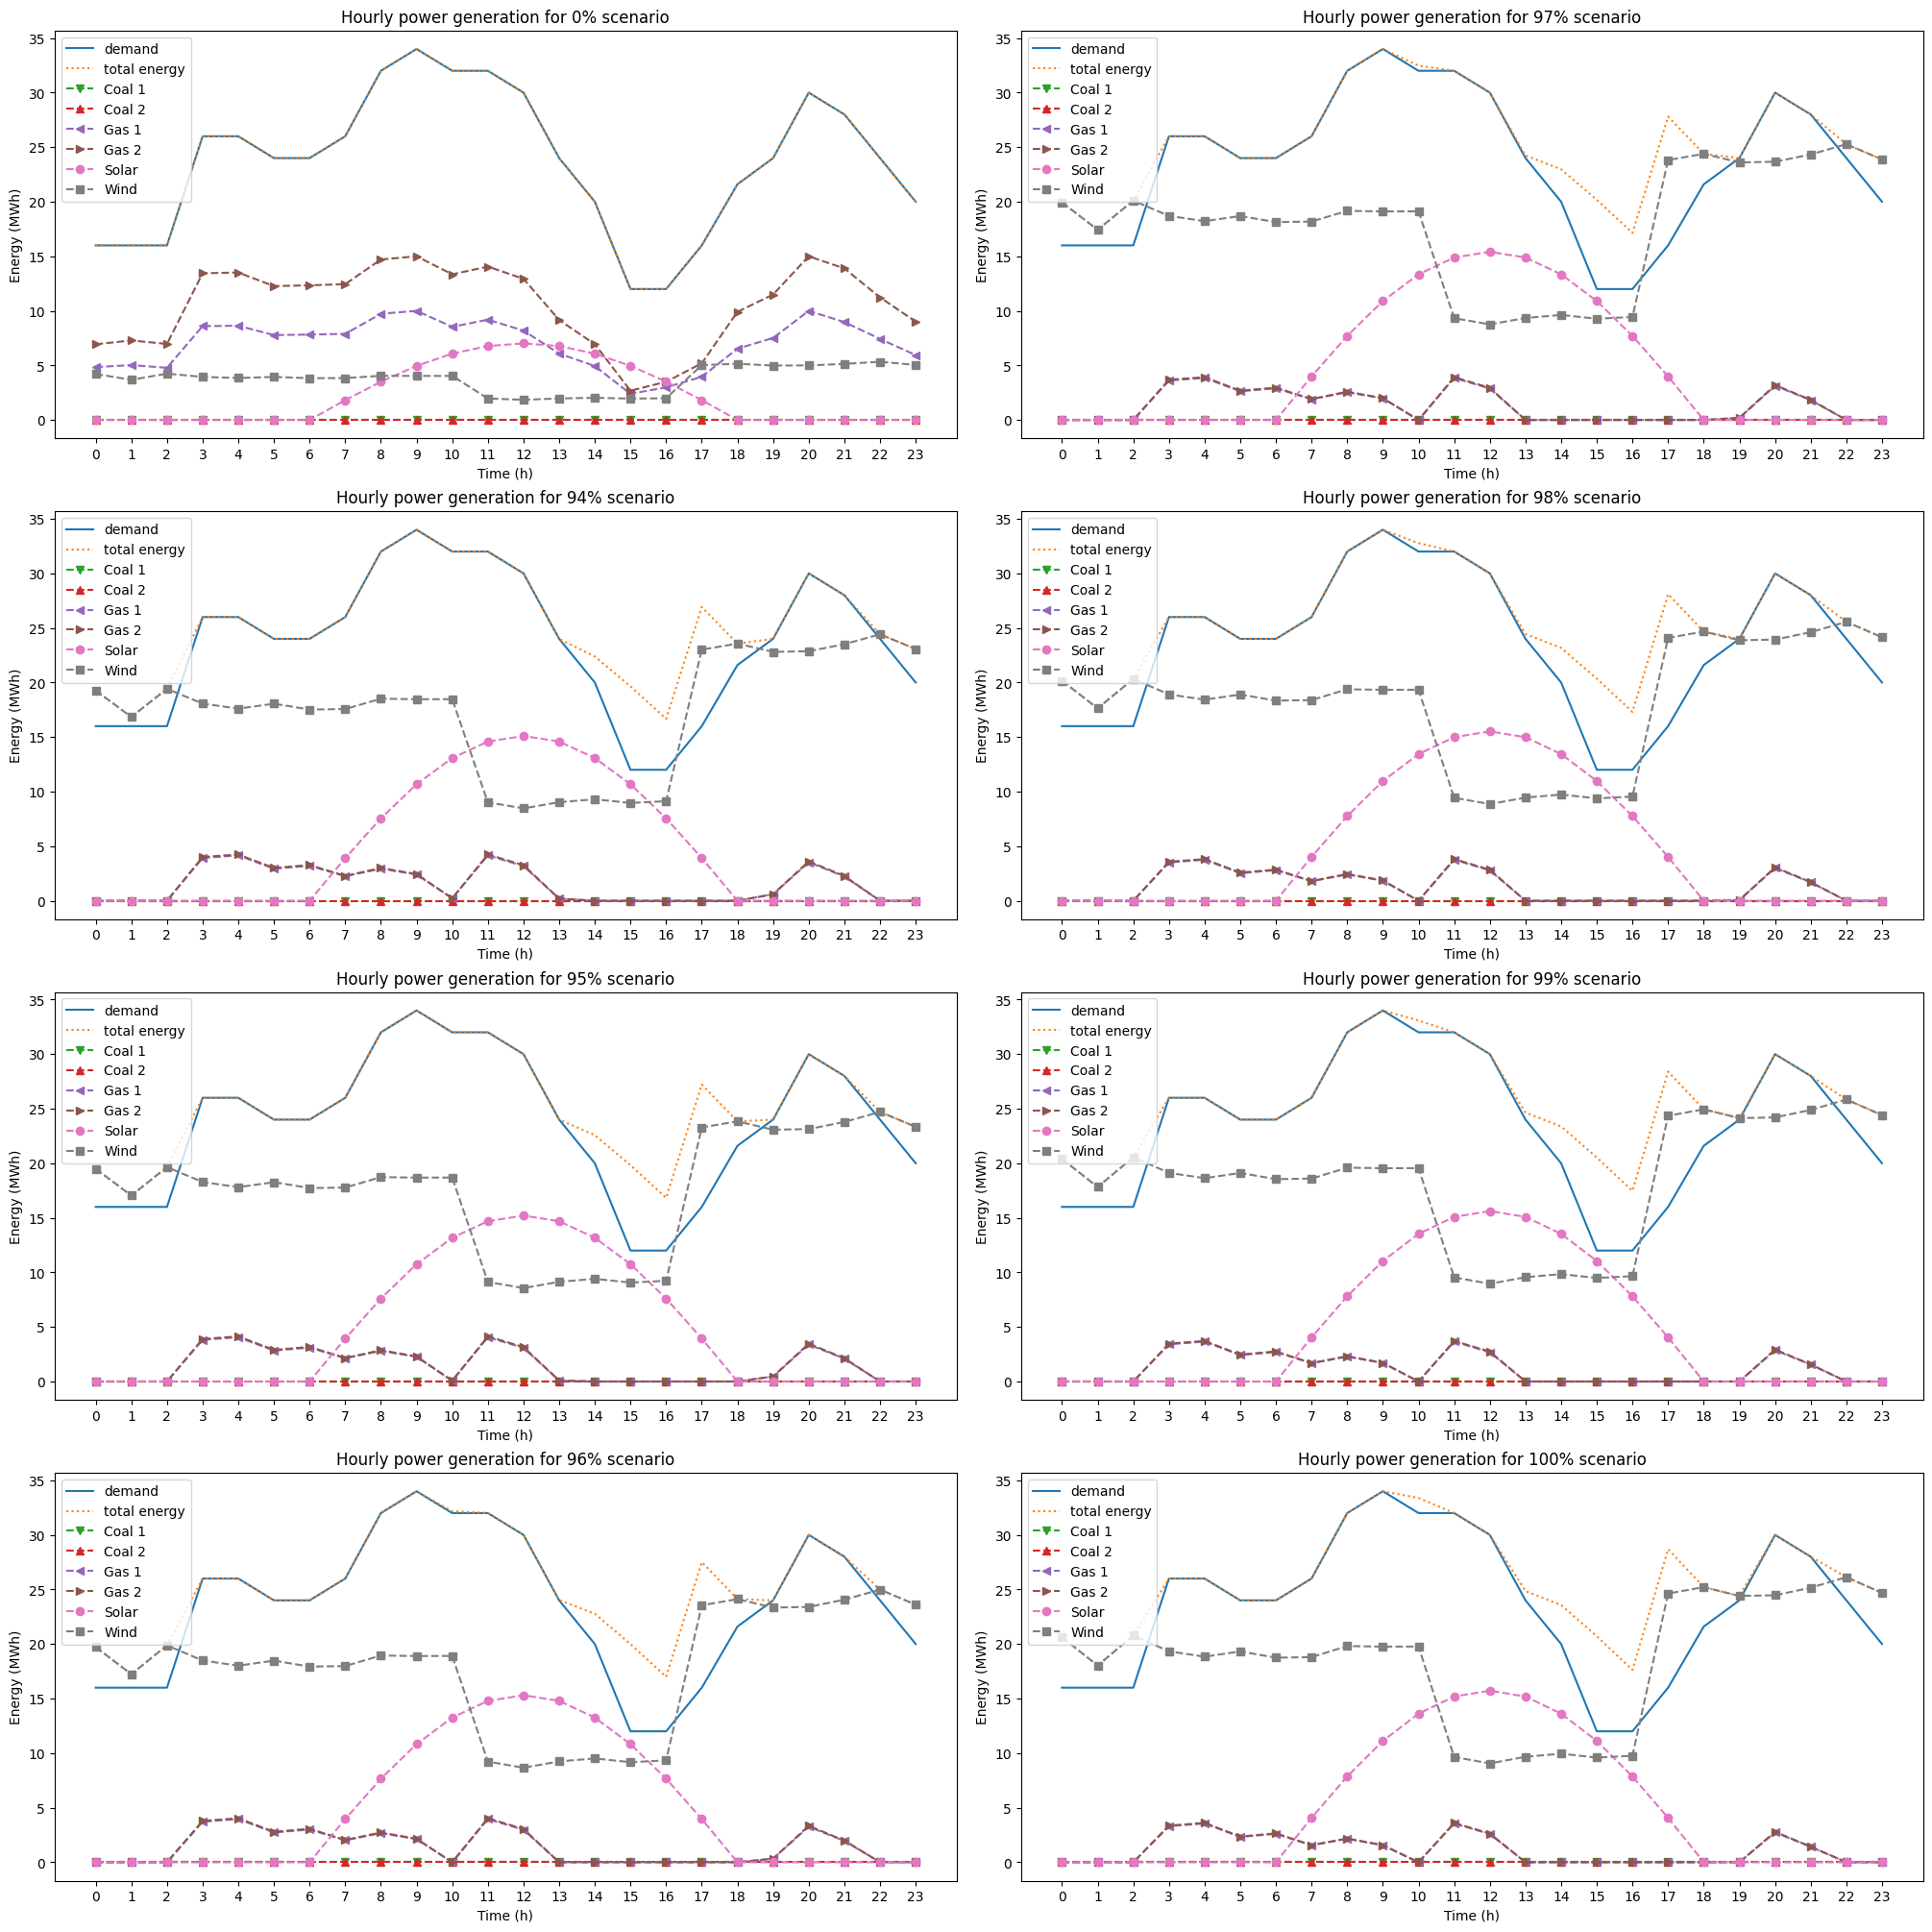

In [9]:
# baseline analysis
fig, ax = plt.subplots(4, 2, layout='constrained', figsize=(20, 20))

markers = ['v', '^', '<', '>', 'o', 's']
for i in range(8):
    n = i%4
    m = i//4
    ax[n, m].plot(t, d, label='demand')
    ax[n, m].plot(t, np.sum(power_generation_2[i, :, :], axis=0), ls=':', label='total energy')
    for j in range(6):
        ax[n, m].plot(t, power_generation_2[i, j, :], ls='--', marker=markers[j], label=power_plants[j])
        
    ax[n, m].set_title(f'Hourly power generation for {RPS_constraints[i]:.0%} scenario')
    ax[n, m].set_xlabel('Time (h)')
    ax[n, m].set_xticks(t)
    ax[n, m].set_ylabel('Energy (MWh)')
    ax[n, m].legend(loc='upper left')

# Part 2 Questions
1. The baseline results in Part 2 have 0 coal plant capacity while in Part 1, the optimization requires ~ 5MWh of coal plants to meet peak energy demand. Instead, Part 2 baseline uses wind power to meet peak energy demand. Both Part 1 and Part 2 maximise the the gas plant capacity to provide power duing nightime. The energy dispatch in Part 1 and Part 2 are qualitatively similar. The gas plant production closely matches the demand curve. The solar production matches the day-night cycle. The coal in part 1 and wind in part 2 both provide a low but steady energy output.
2. Total cost increases as RPS increase. This is because to increase RPS, we need to increase the total renewable energy production. This requires building larger renewable capacity resulting in larger infrastructure costs. However, solar power and wind power generation fluctuates over the day so we still need gas plants to meed peak demand during times when renewable energy production is low. This results in a large increase renewable infrastructure costs, while only a slight moderate in gas plant costs.
3. Curtailment rises as RPS increases. This is because as we increase renewable energy capacity, some renewable energy is produced during low-demand hours. This results in curtailment because there is excess energy produced.
4. Storage will allow us to store excess energy produced when renewable production exceeds demand. Then we can use the stored energy when demand is higher than renewable production. This allows for less curtailment since excess energy can be stored. This also allows for building lower capacity because we don't need as many generators during peak hours if there is stored energy available. This results in lower capital costs as well.

In [10]:
# q = np.arange(n*T).reshape(n, T)
# test = np.arange(24).reshape((1, 24))
# print(test < solar_cap_fact)
# print((q <= n).shape)
# print(np.multiply(q, fuel_cost_per_MWh_2018[:, np.newaxis]))
# print(np.abs(np.diff(q, axis=1)) < R[:, np.newaxis])
# print(np.abs(np.diff(q, axis=1)).shape)
# print(np.sum(q, axis=0))
# print(np.transpose(q) @ (fuel_cost_per_MWh_2018))
# print(q < np.ones((n, 1)))
# r = np.arange(24).reshape(1,24)
# r < solar_cap_fact
# s = np.arange(4).reshape(4,1)
# print(s.T < Pmax)
# print((q < s).shape)
# print(power.shape)

In [ ]:
# plt.plot(t, np.sum(power_generation_2[i, :, :], axis=0))